In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold

In [2]:
def auc(variables, target, basetable):
    X = basetable[variables]
    y= basetable[target]

    logreg=LogisticRegression(max_iter=3000)
    logreg.fit(X,y.values.ravel())
    predictions=logreg.predict_proba(X)[:,1]
    auc=roc_auc_score(y, predictions)
    return auc

def next_best(current_variables, candidate_variables, target, basetable):
    best_auc=-1
    best_variable=None
    for v in candidate_variables:
        auc_v= auc(current_variables+[v],target, basetable)
        if auc_v >= best_auc:
            best_auc=auc_v
            best_variable=v
    return (best_variable,best_auc)

In [3]:

df=pd.read_csv('ANSUR_2_M.csv', encoding = "ISO-8859-1")
#print(df.head())

    
        
#print(df['IsCombatArms'].value_counts())        
        
for column in df.columns:
    print(column)
    
print(df.shape)


print("based on auc below remove the following features")

df=df.drop(['Age',
'palmlength',
'subjectid',
'buttockdepth',
'bimalleolarbreadth',
'shouldercircumference',
'trochanterionheight',
'iliocristaleheight',
'kneeheightsitting',
'lateralfemoralepicondyleheight',
'crotchlengthposterioromphalion',
'crotchheight',
'waistheightomphalion',
'waistdepth',
'interpupillarybreadth',
'bicepscircumferenceflexed',
'kneeheightmidpatella',
'abdominalextensiondepthsitting',
'buttockheight',
'waistfrontlengthsitting'
           ],axis=1)






subjectid
abdominalextensiondepthsitting
acromialheight
acromionradialelength
anklecircumference
axillaheight
balloffootcircumference
balloffootlength
biacromialbreadth
bicepscircumferenceflexed
bicristalbreadth
bideltoidbreadth
bimalleolarbreadth
bitragionchinarc
bitragionsubmandibulararc
bizygomaticbreadth
buttockcircumference
buttockdepth
buttockheight
buttockkneelength
buttockpopliteallength
calfcircumference
cervicaleheight
chestbreadth
chestcircumference
chestdepth
chestheight
crotchheight
crotchlengthomphalion
crotchlengthposterioromphalion
earbreadth
earlength
earprotrusion
elbowrestheight
eyeheightsitting
footbreadthhorizontal
footlength
forearmcenterofgriplength
forearmcircumferenceflexed
forearmforearmbreadth
forearmhandlength
functionalleglength
handbreadth
handcircumference
handlength
headbreadth
headcircumference
headlength
heelanklecircumference
heelbreadth
hipbreadth
hipbreadthsitting
iliocristaleheight
interpupillarybreadth
interscyei
interscyeii
kneeheightmidpatella
k

In [4]:
#print(df['Branch'].unique())
df['IsCombatArms']=0
df['IsCombatSupport']=0
df['IsCombatServiceSupport']=0
for key,item in df.iterrows():
    if item['Branch']=='Combat Arms':
        df.loc[key,'IsCombatArms']=1
    elif item['Branch']=='Combat Support':
        df.loc[key,'IsCombatSupport']=1
    elif item['Branch']=='Combat Service Support':        
        df.loc[key,'IsCombatServiceSupport']=1

df['BMI']=df['Weightlbs']*703/df['Heightin']**2

df['IsOverWeight']=df['BMI'].apply(lambda x:  1 if (x>=25) and (x<=29.9)  else 0 )
df['IsNormalWeight']=df['BMI'].apply(lambda x:  1 if (x>=18.5) and (x<=24.9)  else 0 )
df['IsUnderWeight']=df['BMI'].apply(lambda x:  1 if (x<18.5) else 0 )

df['IsTallHeight']=df['Heightin'].apply(lambda x:  1 if (x>69)  else 0 )
df['IsNormalHeight']=df['Heightin'].apply(lambda x:  1 if (x>=64) and (x<=69)  else 0 )
df['IsShortHeight']=df['Heightin'].apply(lambda x:  1 if (x<64)  else 0 )

df['BMI_class']=''
df['BMI_color']=''
df['Heightin_color']=''
for key,item in df.iterrows():
    x=item['BMI']
    if (x>=25) and (x<=29.9):
        df.loc[key,'BMI_class']='Over weight'
        df.loc[key,'BMI_color']='yellow'
    elif (x>=18.5) and (x<=24.9):
        df.loc[key,'BMI_class']='Normal'
        df.loc[key,'BMI_color']='green'
    else :
        df.loc[key,'BMI_class']='Under weight'
        df.loc[key,'BMI_color']='purple'
    
    if item['IsTallHeight']==1:
        df.loc[key,'Heightin_color']='orange'
    elif item['IsNormalHeight']==1:
        df.loc[key,'Heightin_color']='red'
    elif item['IsShortHeight']==1:        
        df.loc[key,'Heightin_color']='blue'



In [15]:
NUMERIC=[item for item in df.select_dtypes([np.number]).columns ]
sel = VarianceThreshold(threshold=.005)
sel.fit(df[NUMERIC]/df[NUMERIC].mean())

mask=sel.get_support()
print(mask)

reduced_df=df[NUMERIC].loc[:,mask]

variance_columns=[item for item in reduced_df.columns]
print(variance_columns)

#for item in df['BMI_class']:
    #print(item)


[False False False False False False False False False False False False
  True False False  True False False  True  True False  True  True False
  True  True False False False False  True  True False False False False
 False False False False False  True False  True  True False  True  True
 False False False False False False False False False False False False
 False False False  True  True False False False False False  True  True
  True False False  True  True False  True  True  True  True  True  True
  True  True  True  True  True]
['buttockcircumference', 'calfcircumference', 'chestcircumference', 'chestdepth', 'crotchlengthomphalion', 'earbreadth', 'earprotrusion', 'elbowrestheight', 'forearmcircumferenceflexed', 'forearmforearmbreadth', 'heelbreadth', 'hipbreadthsitting', 'interscyei', 'lateralmalleolusheight', 'lowerthighcircumference', 'thighcircumference', 'thighclearance', 'waistbreadth', 'waistcircumference', 'weightkg', 'SubjectNumericRace', 'DODRace', 'Weightlbs', 'IsCom

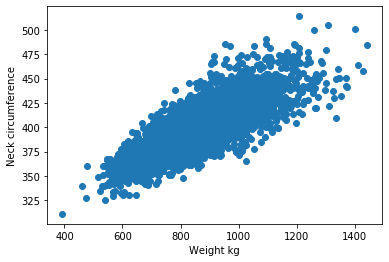

In [6]:
plt.scatter(x='weightkg',y='neckcircumference', data=df)
plt.ylabel('Neck circumference')
plt.xlabel('Weight kg')
plt.show()

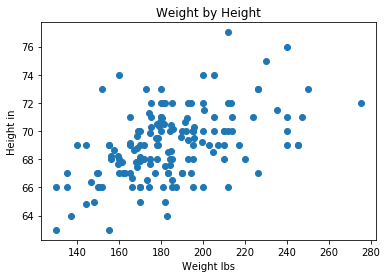

Text(0.5, 1, 'Avg Weight by Ethnicity')

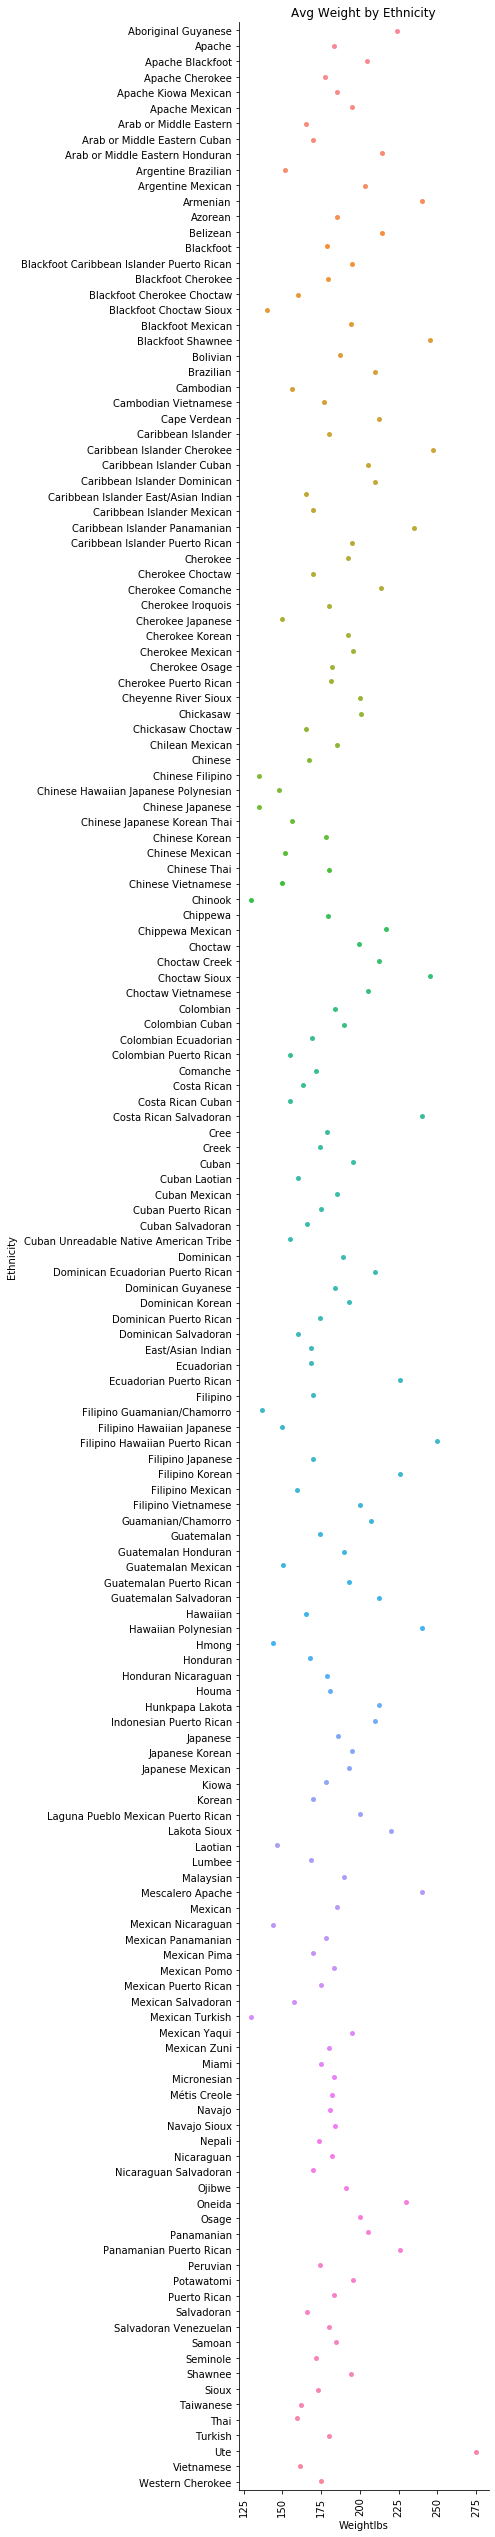

In [7]:
grouped=df.groupby('Ethnicity')

labels=[]
for name, group in grouped:
    labels.append(name)


#print(labels)    

summary_df=pd.DataFrame(columns=['Ethnicity','Weightlbs','Heightin'])
for name, group in df.groupby('Ethnicity'):
    weightlbs=group['Weightlbs'].mean()
    heightin=group['Heightin'].mean()
    index=len(summary_df)
    summary_df.loc[index]=[name,weightlbs,heightin]
    #x=np.arange(weight.size())
    #print(name,weight)
    #plt.scatter(y=weight, label=name)


plt.scatter(y='Heightin',x='Weightlbs',data=summary_df)
plt.xlabel("Weight lbs")
plt.ylabel("Height in")
plt.title("Weight by Height")
plt.show()

sns.catplot(x='Weightlbs',y='Ethnicity' ,data=summary_df,height=35,aspect=.2)
plt.xticks(rotation=90)
plt.title('Avg Weight by Ethnicity')
#x=np.arange(len(weight))
#plt.scatter(x=x,y=weight,label=labels)
#plt.legend(labels)
#df['Weightlbs'].plot()

In [8]:
model=TSNE(learning_rate=50)

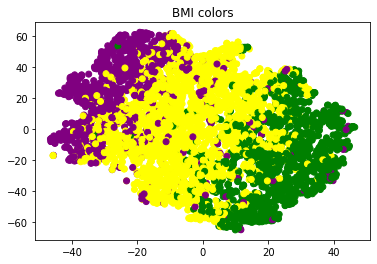

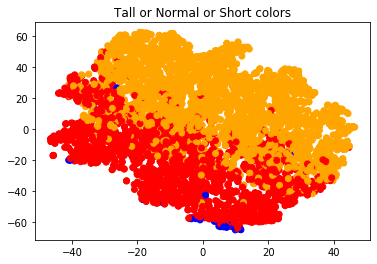

In [9]:
#non_numeric=['BMI_class','Height_class','Gender','Component','Branch']
numeric_df=df.select_dtypes(exclude='object')
#X=df.drop(non_numeric,axis=1)

#print(numeric_df.columns)

transformed=model.fit_transform(numeric_df)

xs=transformed[:,0]
ys=transformed[:,1]

color_labels=df['BMI_color']
plt.scatter(xs,ys,c=color_labels)
plt.title('BMI colors')
plt.show()

color_labels=df['Heightin_color']
plt.scatter(xs,ys,c=color_labels)
plt.title('Tall or Normal or Short colors')
plt.show()

In [10]:
print(" Weight lbs {} Height ft {}".format(df['Weightlbs'].mean(),df['Heightin'].mean()/12))

 Weight lbs 188.0048995590397 Height ft 5.83631389841581


In [11]:
candidate_variables=[]

[candidate_variables.append(item) for item in df.select_dtypes([np.number]).columns if item!='IsCombatArms' ]
current_variables=[]
auc_scores=[]
target=['IsCombatArms']
max_number_variables=len(candidate_variables)

number_iterations=min(max_number_variables, int(len(candidate_variables)/4))

for i in range(0,number_iterations):
    print("{} of {}".format(i,number_iterations))
    next_variable,auc_variable= next_best(current_variables, candidate_variables, target, df)
    current_variables=current_variables+[next_variable]
    auc_scores=auc_scores+[auc_variable]
    candidate_variables.remove(next_variable)

#print(current_variables)
x=np.array(range(0,len(auc_scores)))
y = np.array(auc_scores)

plt.figure(figsize=(22,22))
plt.xticks(x, current_variables, rotation = 90)
plt.plot(x,y)
plt.show()

0 of 22
1 of 22
2 of 22
3 of 22
4 of 22
5 of 22
6 of 22
7 of 22
8 of 22
9 of 22
10 of 22
11 of 22
12 of 22
13 of 22
14 of 22
15 of 22
16 of 22
17 of 22
18 of 22


KeyboardInterrupt: 

In [ ]:
#plt.scatter(x='Age',y='Weightlbs',data=df)
#plt.xlabel('Age')
#plt.ylabel('Weight lbs')
#plt.show()
#df.drop('Age',axis=1)

In [ ]:
NUMERIC=[item for item in df.select_dtypes([np.number]).columns ]
        
X=df[NUMERIC]
y=pd.factorize(df['BMI_class'])[0]
LABELS=df['BMI_class'].unique()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, stratify = y, random_state = 42)

lr=LogisticRegression(C=100)

lr.fit(X_train,y_train)

y_pred=lr.predict(X_test)

Underweight=y_pred[y_pred==2]
Overweight=y_pred[y_pred==0] 
Normal=y_pred[y_pred==1]

buffer=pd.Series(y_pred)
buffer.value_counts().plot(kind='bar')
plt.annotate(str(len(Overweight)), xy=(0,len(Overweight)))
plt.annotate(str(len(Normal)), xy=(1,len(Normal)))
plt.annotate(str(len(Underweight)), xy=(2,len(Underweight)))
plt.show()

print("Logistic Regression Accuracy", accuracy_score(y_test,lr.predict(X_test)))



In [ ]:
the_confusion_matrix = confusion_matrix(y_test, y_pred)
class_names=[1,2,3]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(the_confusion_matrix), annot=True, cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
xs=df['Weightlbs']
ys=df['Heightin']
color_labels=df['BMI_color']

_=plt.scatter(xs,ys,c=color_labels)
plt.xlabel('Weight lbs')
plt.ylabel('Height in')
plt.show()

points=np.column_stack((xs,ys))

In [ ]:
# Create a KMeans instance with 3 clusters: model
model = KMeans(n_clusters=3)

# Fit model to points
model.fit(points)

#print(model.inertia_)

new_points=np.random.permutation(points)

# Determine the cluster labels of new_points: labels
new_labels = model.predict(new_points)

# Print cluster labels of new_points
#print(new_labels)

xs = new_points[:,0]
ys = new_points[:,1]

plt.clf()
# Make a scatter plot of xs and ys, using labels to define the colors
_=plt.scatter(xs,ys,c=color_labels, alpha=0.05)

# Assign the cluster centers: centroids
centroids = model.cluster_centers_
# Assign the columns of centroids: centroids_x, centroids_y
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

# Make a scatter plot of centroids_x and centroids_y
_=plt.scatter(centroids_x,centroids_y, marker='D',s=50)
plt.show()

In [ ]:
NUMERIC=[item for item in df.select_dtypes([np.number]).columns ]
X=df[NUMERIC]
#print(X.head())

pca=PCA()

scaler = StandardScaler()

pipeline= make_pipeline(scaler, pca)

pipeline.fit(X)

coefficients = range(pca.n_components_)

plt.bar(coefficients, pca.explained_variance_)
plt.xticks(rotation=90)
plt.xlabel('pca features')
plt.ylabel('variance')

plt.show()


In [ ]:
print ("Neck circumference differs significantly")
df['neckcircumferencebase'].plot()
plt.show()

NUMERIC=['neckcircumferencebase']
X=df[NUMERIC]
y=pd.factorize(df['BMI_class'])[0]
LABELS=df['BMI_class'].unique()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, stratify = y, random_state = 42)

lr=LogisticRegression(C=100)

lr.fit(X_train,y_train)

y_pred=lr.predict(X_test)

Underweight=y_pred[y_pred==2]
Overweight=y_pred[y_pred==0] 
Normal=y_pred[y_pred==1]

buffer=pd.Series(y_pred)
buffer.value_counts().plot(kind='bar')
plt.annotate(str(len(Overweight)), xy=(0,len(Overweight)))
plt.annotate(str(len(Normal)), xy=(1,len(Normal)))
plt.annotate(str(len(Underweight)), xy=(2,len(Underweight)))
plt.show()

print("Only Neck circumference - Logistic Regression Accuracy", accuracy_score(y_test,lr.predict(X_test)))

